# Multinomial Naive Bayes

A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class. More formally, if I want to calculate the probability of observing features $ F_1 ... F_n $, given some class c, under the Naive Bayes assumption the following holds:

$$ P(f_1,...,f_n|c)=\prod_{i=1}^{n} P(f_i|c) $$

This means that when I want to use a Naive Bayes model to classify a new example, the posterior probability is much simpler to work with:

$$ P(c|f_1,...,f_n) \propto P(c)P(f_1|c)...P(f_n|c) $$

Of course these assumptions of independence are rarely true, but in practice Naive Bayes models have performed surprisingly well, even on complex tasks where it is clear that the strong independence assumptions are false.

Up to this point we have said nothing about the distribution of each feature. In other words, we have left $ p(f_i|c) $ undefined. The term Multinomial Naive Bayes simply lets us know that each $ p(f_i|c) $ is a multinomial distribution, rather than some other distribution (Gaussian, Bernoulli). This works well for data which can easily be turned into counts, such as word counts in text.

So Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.

In [1]:
import numpy as np
import string

import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin

### Naive Bayes from scratch

In [2]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
        
    def __init__(self):
        '''
        initialize naive basyes parameters for later use
        '''
        self.class_probs = None
        self.log_label_word_proba = None
    
    def fit(self, X, y):
        '''
        Fit/train model
        X: a matrix of data values (rows are samples, columns are attributes)
        y: a vector of corresponding target values
        '''
        # class counts and labels to get class prior (probability)
        labels, labels_counts = np.unique(y, return_counts=True)
        self.log_class_prior = np.log(labels_counts / y.size)
        
        # lable-word priors
        vocab_size = X.shape[1]
        label_vecs = {l: X[y == l] for l in labels} # vocab vector per label
        label_word_count = {l: np.sum(label_vecs[l]) for l in labels} # word count per label
        label_divisor = {l: label_word_count[l] + vocab_size + 1 for l in labels}
        
        # word_in_class_probabilities
        label_word_proba = np.array([(np.sum(label_vecs[l], axis=0) + 1) / label_divisor[l] for l in labels])
        label_word_proba = np.squeeze(label_word_proba)
        self.log_label_word_proba = np.log(label_word_proba)
        
    def predict_log_proba(self, X):
        '''
        Predict logarithm of probability estimates for class labels
        The returned estimates for all classes are ordered by the label of classes
        X: a matrix of data values (rows are samples, columns are attributes)
        '''
        return self.log_class_prior + np.array(X * self.log_label_word_proba.T)  

    def predict(self, X):
        '''
        Predict class labels using fitted/trained model
        X: a matrix of data values (rows are samples, columns are attributes)
        '''
        return np.argmax(self.predict_log_proba(X), axis=1)
    

### We will now classify the "20 newsgroups" data set using our own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

In [3]:
X_train, y_train = fetch_20newsgroups(remove = ('headers', 'footer', 'quotes'), subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(remove = ('headers', 'footer', 'quotes'), subset='test', return_X_y=True)

In [4]:
def show_results(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Per Class Evaluation: \n' + classification_report(y_test,y_pred))

### Compare our NaiveBayes to sklearn implementation

In [5]:
# Handmade Naive bayes with CountVectorizer
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1)), NaiveBayes())
show_results(clf)

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       319
           1       0.59      0.74      0.65       389
           2       0.50      0.01      0.02       394
           3       0.54      0.73      0.62       392
           4       0.80      0.61      0.69       385
           5       0.57      0.80      0.67       395
           6       0.85      0.73      0.79       390
           7       0.87      0.77      0.82       396
           8       0.91      0.82      0.86       398
           9       0.94      0.78      0.85       397
          10       0.82      0.93      0.87       399
          11       0.58      0.85      0.69       396
          12       0.74      0.53      0.62       393
          13       0.79      0.80      0.79       396
          14       0.71      0.83      0.76       394
          15       0.50      0.93      0.65       398
          16       0.65      0.74      0.70       364
    

In [6]:
# sklearn Naive bayes with CountVectorizer
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1)), MultinomialNB())
show_results(clf)

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       319
           1       0.59      0.74      0.65       389
           2       0.50      0.01      0.02       394
           3       0.54      0.73      0.62       392
           4       0.80      0.61      0.69       385
           5       0.57      0.80      0.67       395
           6       0.85      0.73      0.79       390
           7       0.87      0.77      0.82       396
           8       0.91      0.82      0.86       398
           9       0.94      0.78      0.85       397
          10       0.82      0.93      0.87       399
          11       0.58      0.85      0.69       396
          12       0.74      0.53      0.62       393
          13       0.79      0.80      0.79       396
          14       0.71      0.83      0.76       394
          15       0.50      0.93      0.65       398
          16       0.65      0.74      0.70       364
    

## Learning Curve

A learning curve is a plot of model learning performance over experience or time.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves. This gives us valuable insight into how the training of our model went and whether or not we should be worried about overfitting or underfitting.

In [7]:
def plot_learning_curve(clf):
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)  

    # Plot
    fig, axes = plt.subplots(1,1, figsize=(12, 8))
    axes.set_title('Learning Curves (Naive Bayes)')
    axes.set_ylim(*(0.01, 1.01))
    axes.set_xlabel('Examples')
    axes.set_ylabel('Score')
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()

#### Just right

Here we add standard parameters to see what a good learning curve looks like. The train and test start far apart and slowly come together over the course of the training. The training score should get lower as the CV score gets higher. By the end the lines should be straightening out with the training set score only a buit higher than that of the CV score.

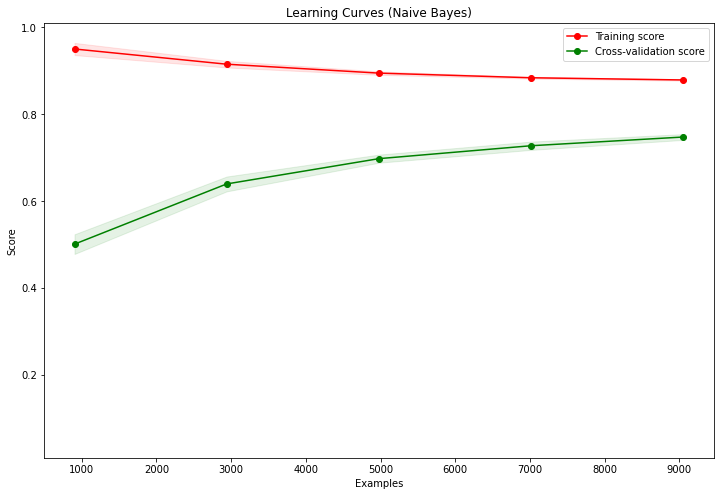

In [8]:
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=50000), MultinomialNB())
plot_learning_curve(clf)

#### Overfit

Here we will train with a large amount of only 50-grams, this creates heavy overfitting which is apparent in the graph as a huge gap between the lines that doesnt get smaller with amount of samples.

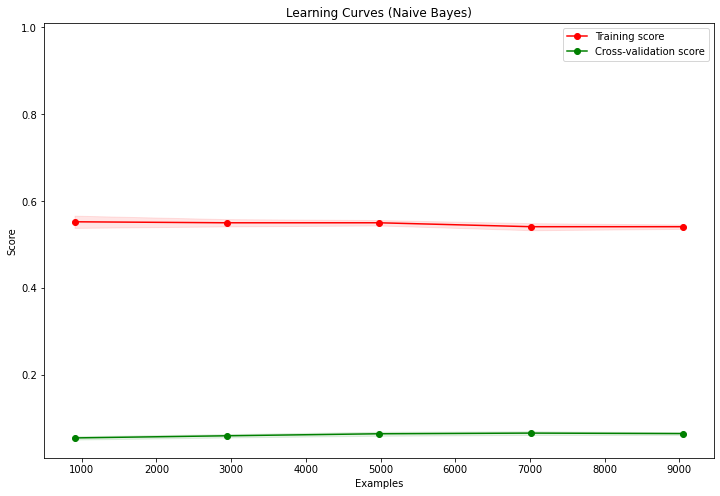

In [9]:
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(50,50)), MultinomialNB())
plot_learning_curve(clf)

#### Underfit

Here we use a very minimal amount of features (100). This leads to underfitting. We can see below that the training and validation scores dont start very far apart and the corss-validation score does not improve that much over the course of the training.

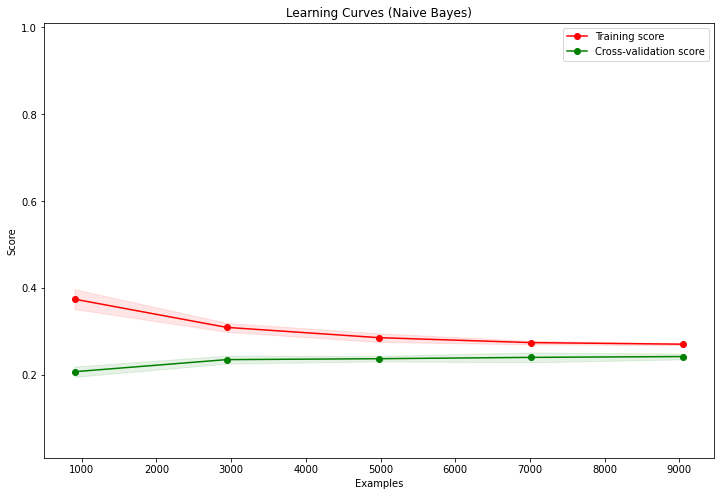

In [10]:
clf = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(1,1), max_features=100), MultinomialNB())
plot_learning_curve(clf)

## Hyper-parameter Optimization

Another way of optimizing out model is  Hyper-parameter Optimization. Here we take our model (or somtimes even multiple types of models) and train them with different hyper-parameters. We find the error for each model using cross validation and then train the next model. At the end we choose the model with the lowest error (or whatever metric we choose) across all trained models. In this way we can tweak our model to get the most out of our data. 

The best current optimizer is BayesSearchCV but it is in beta still so we will use the standard RandomSearchCV from sklearn. 

Grid Search can be thought of as an exhaustive search for selecting a model. In Grid Search, the data scientist sets up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. In this approach, every combination of hyperparameter values is tried which can be very inefficient.

Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score.

While GridSerach is exaustive, it takes a lot of time to run. Random Search tends to be able to find a comparible if not better result and in a fraction of the time.

In [11]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'tfidfvectorizer__binary': [True, False],
    'tfidfvectorizer__norm': [None, 'l1', 'l2'],
    'tfidfvectorizer__max_features': (5000, 10000, 20000,30000,40000,50000, None),
}

pipeline = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())
grid_search = RandomizedSearchCV(pipeline, param_grid, return_train_score=True, verbose=10, n_jobs=-1)

clf_opt = grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.5min remaining:   46.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.8min remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


In [12]:
clf_opt.best_params_

{'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__ngram_range': (1, 4),
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__binary': False}

In [13]:
# We use best model to predict and print results  
y_pred = clf_opt.predict(X_test)
print('Per Class Evaluation: \n' + classification_report(y_test,y_pred))

Per Class Evaluation: 
              precision    recall  f1-score   support

           0       0.80      0.26      0.39       319
           1       0.72      0.70      0.71       389
           2       0.70      0.63      0.66       394
           3       0.61      0.74      0.67       392
           4       0.83      0.68      0.74       385
           5       0.79      0.77      0.78       395
           6       0.81      0.81      0.81       390
           7       0.85      0.80      0.82       396
           8       0.88      0.86      0.87       398
           9       0.91      0.82      0.86       397
          10       0.80      0.96      0.87       399
          11       0.64      0.87      0.74       396
          12       0.74      0.55      0.63       393
          13       0.82      0.76      0.79       396
          14       0.72      0.81      0.77       394
          15       0.40      0.94      0.56       398
          16       0.66      0.71      0.69       364
    